In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from IPython.display import Image 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Autoencoder Class definition and data load

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=kwargs["embedding_dim"]
        )
        self.encoder_output_layer = nn.Linear(
            in_features=kwargs["embedding_dim"], out_features=kwargs["embedding_dim"]
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=kwargs["embedding_dim"], out_features=kwargs["embedding_dim"]
        )
        self.decoder_output_layer = nn.Linear(
            in_features=kwargs["embedding_dim"], out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)

        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)

        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)

        return reconstructed, code

model = Autoencoder(input_shape=784, embedding_dim=128)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

for data, target in train_loader: #with this you can know the dimensions of the data
    print("Batch, channels, height, width: ", data.shape)               # batch_size = 128, channels = 1 (grey scale), image = 28x28
    break

print("How many examples: ", len(train_dataset))

#random = torch.rand(1,784)
#ou,co = model(random)
#print(co.shape)
#print(ou.shape)
#reconstructed = ou.view(-1,1,28,28)
#coded = co.view(-1,1,16,8)
#print(coded.shape)
#print(reconstructed.shape)

Batch, channels, height, width:  torch.Size([128, 1, 28, 28])
How many examples:  60000


### Training: plot Reconstructed - Original - Coded

epoch : 1/20, loss = 0.060152


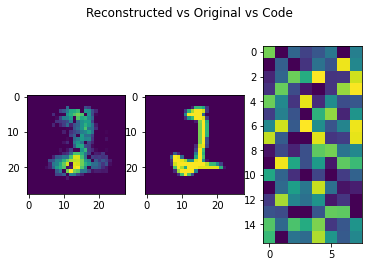

epoch : 2/20, loss = 0.032153


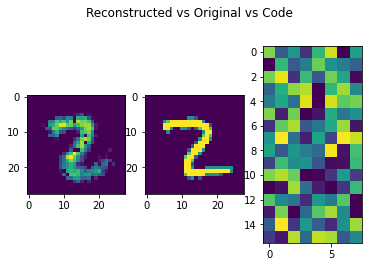

epoch : 3/20, loss = 0.026252


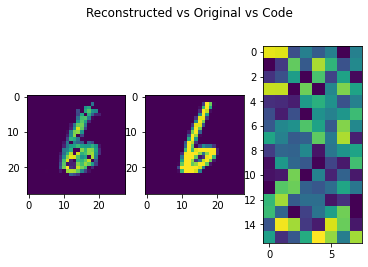

epoch : 4/20, loss = 0.023543


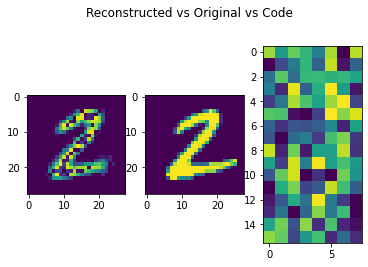

epoch : 5/20, loss = 0.021909


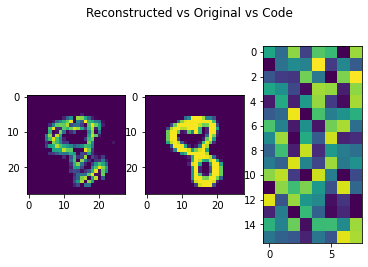

epoch : 6/20, loss = 0.020737


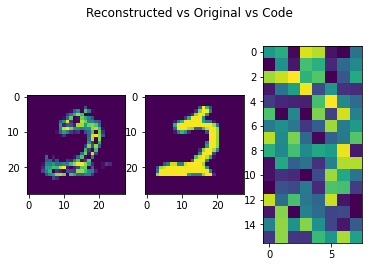

epoch : 7/20, loss = 0.019844


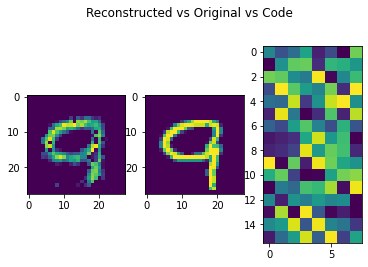

epoch : 8/20, loss = 0.019173


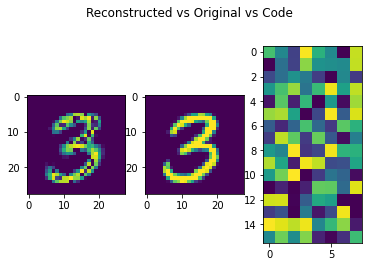

epoch : 9/20, loss = 0.018628


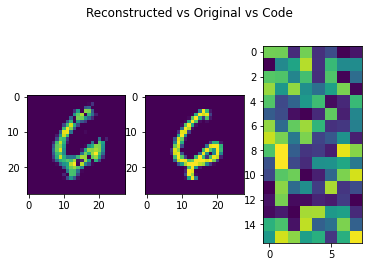

epoch : 10/20, loss = 0.018171


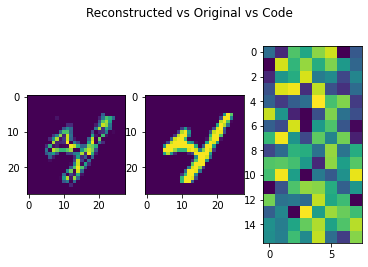

epoch : 11/20, loss = 0.017784


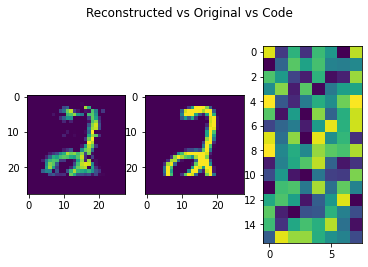

epoch : 12/20, loss = 0.017458


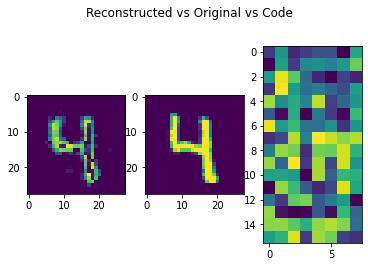

epoch : 13/20, loss = 0.017176


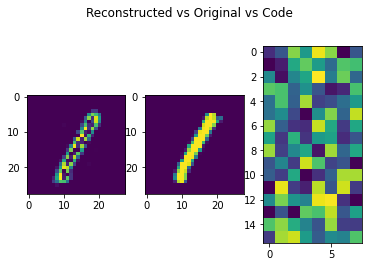

epoch : 14/20, loss = 0.016932


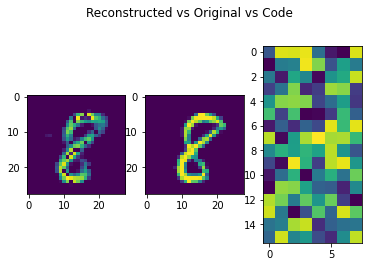

epoch : 15/20, loss = 0.016713


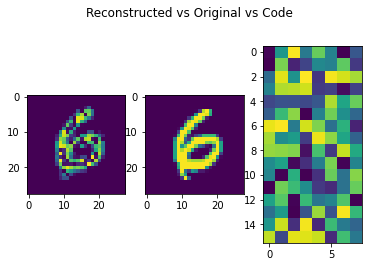

epoch : 16/20, loss = 0.016516


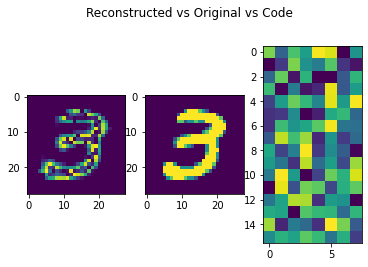

epoch : 17/20, loss = 0.016335


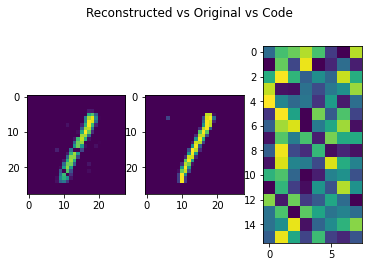

epoch : 18/20, loss = 0.016173


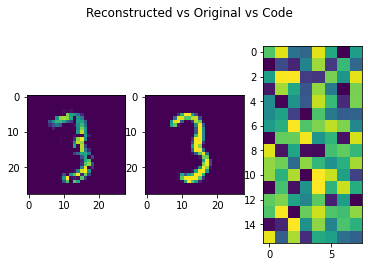

epoch : 19/20, loss = 0.016021


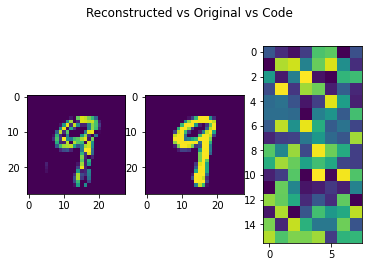

epoch : 20/20, loss = 0.015880


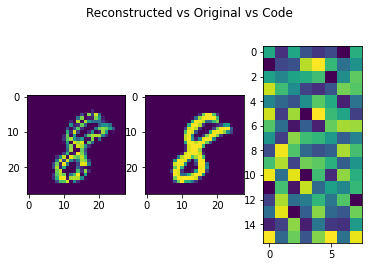

In [3]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, code = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step() #update the weights (net.parameters)
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

    reconstructed = outputs.view(-1,1,28,28)
    original = batch_features.view(-1,1,28,28)
    coded = code.view(-1,1,16,8)
    img = T.ToPILImage()(reconstructed[0]) # plot the first element of the last batch
    img2 = T.ToPILImage()(original[0])
    img_code = T.ToPILImage()(coded[0])

    
    plt.subplot(131)
    imgplot = plt.imshow(img)
    plt.subplot(132)
    imgplot2 = plt.imshow(img2)
    plt.subplot(133)
    imgplot3 = plt.imshow(img_code)
    plt.suptitle("Reconstructed vs Original vs Code")
    plt.show()


In [ ]:
### Save the model and test it

In [5]:
PATH = './ae01.pth'
torch.save(model.state_dict(), PATH) #save in a dictionary all parameters

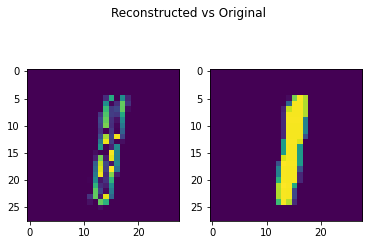

In [6]:
net = Autoencoder(input_shape=784, embedding_dim=128) #create new model
net.load_state_dict(torch.load(PATH))  #load the trained parameters from the dictionary
#ABOVE IS OPTIMAL
#We already have out model built

for batch_features, _ in test_loader: 
    batch_features = batch_features.view(-1, 784) #transform the images 28x28 to 784 vectors
    outputs, _ = model(batch_features) #generate the outputs

reconstructed = outputs.view(-1,1,28,28) # it's mandatory to transform the tensor to a representation that allows plotting
original = batch_features.view(-1,1,28,28)
img = T.ToPILImage()(reconstructed[0]) # plot the first element of the last batch
img2 = T.ToPILImage()(original[0])


plt.subplot(121)
imgplot = plt.imshow(img)
plt.subplot(122)
imgplot2 = plt.imshow(img2)
plt.suptitle("Reconstructed vs Original")
plt.show()

### It seems like the model learns that the important features of the handwriten numbers are the edges. The autoencoder loss the interior of the numbers and just retains its edges.